In [1]:
import numpy as np
import tensorflow as tf

2025-02-21 17:15:25.115279: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-21 17:15:25.285660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740154525.355602  278483 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740154525.373501  278483 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-21 17:15:25.543679: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

## Wczytanie danych

In [2]:
dataset_path = 'data'
img_size = (100, 100)
batch_size = 16

In [31]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
)

Found 16242 files belonging to 10 classes.
Using 12994 files for training.


In [32]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
)

Found 16242 files belonging to 10 classes.
Using 3248 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['Central Serous Chorioretinopathy [Color Fundus]', 'Diabetic Retinopathy', 'Disc Edema', 'Glaucoma', 'Healthy', 'Macular Scar', 'Myopia', 'Pterygium', 'Retinal Detachment', 'Retinitis Pigmentosa']


In [6]:
import matplotlib.pyplot as plt

2025-02-21 15:20:17.539634: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


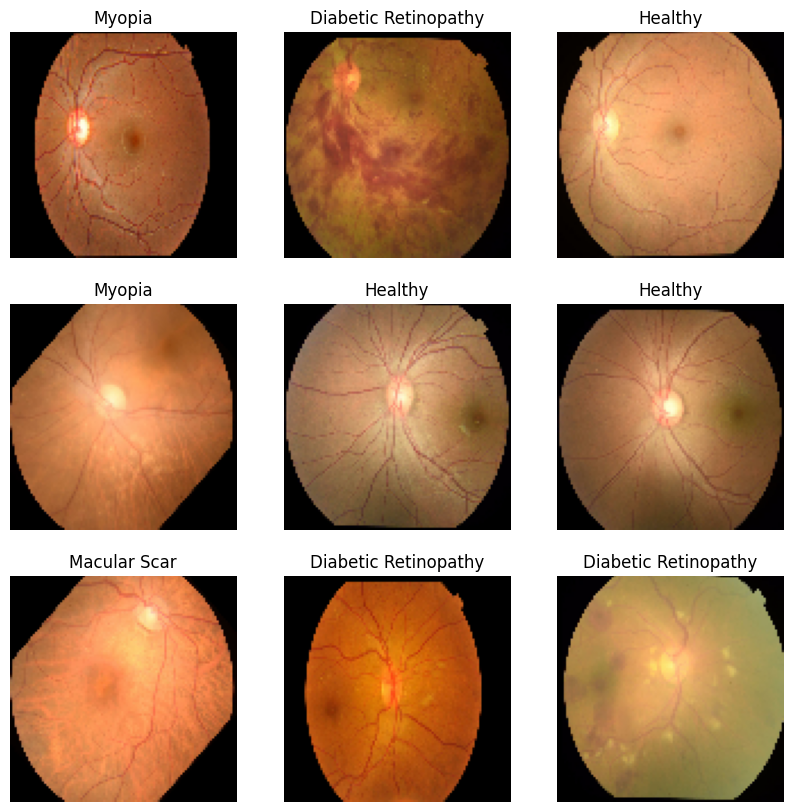

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
def draw_plots(training_history):
    loss = training_history.history['loss']
    accuracy = training_history.history['accuracy']
    val_loss = training_history.history['val_loss']
    val_accuracy = training_history.history['val_accuracy']

    #Loss
    plt.figure(figsize=(8, 6))
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    #Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## Pierwszy model

In [9]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [10]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [31]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [32]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [14]:
training_history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=40,
  callbacks = [early_stopping]
)

NameError: name 'model' is not defined

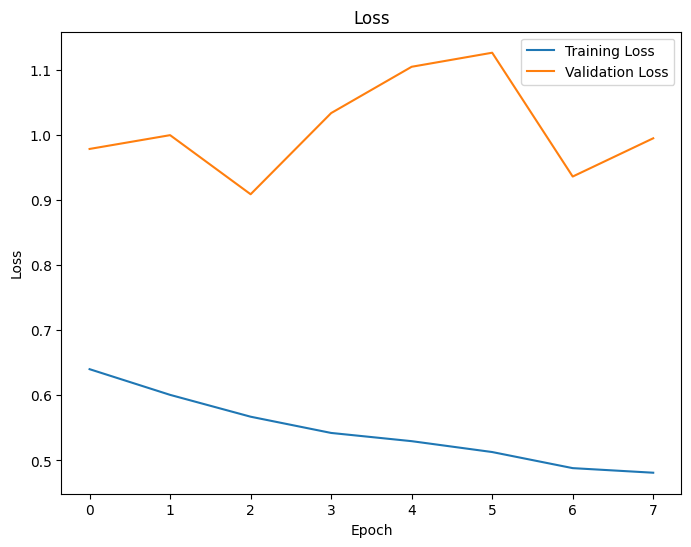

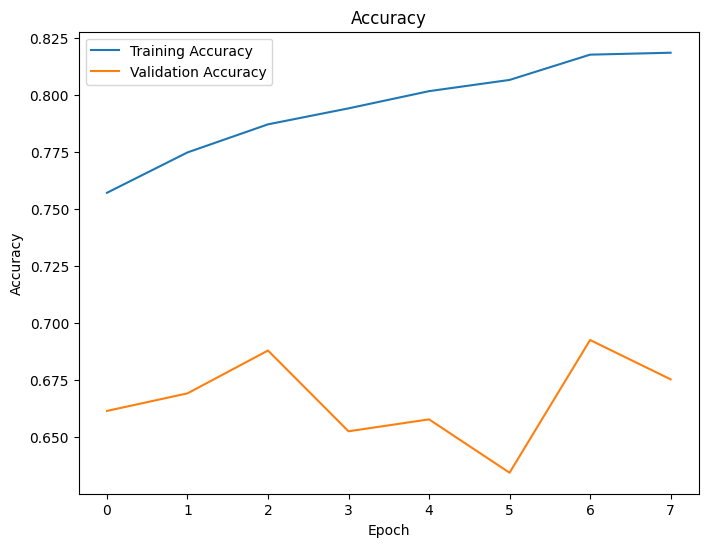

In [39]:
draw_plots(training_history)

In [40]:
loss, accuracy = model.evaluate(val_ds)
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Loss: {loss:.4f}')

  1/102 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7500 - loss: 0.4712

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6881 - loss: 0.9484
Validation Accuracy: 0.6752
Validation Loss: 0.9946


In [41]:
true_labels = np.concatenate([y.numpy() for x, y in val_ds])
predictions = model.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [8]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

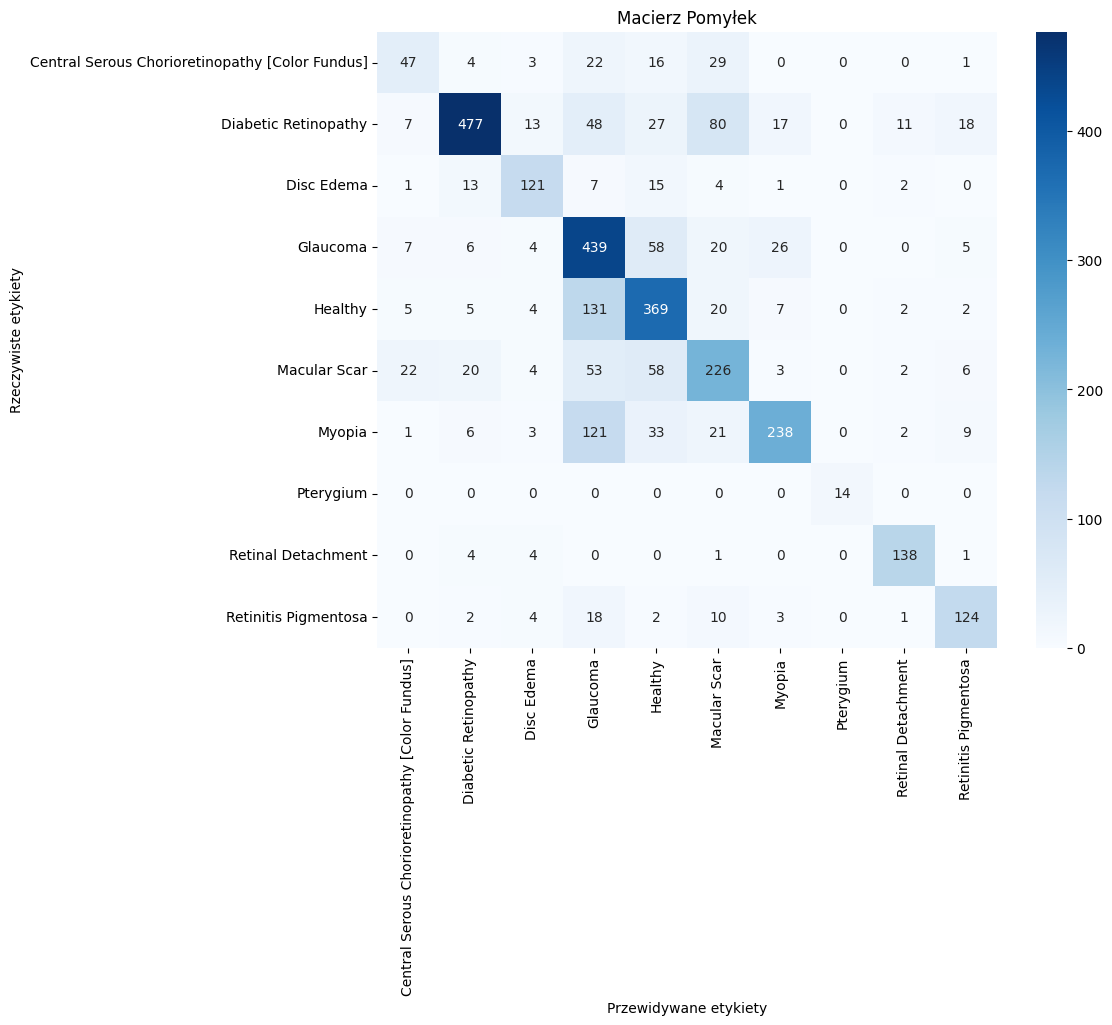

In [43]:
cm = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Przewidywane etykiety")
plt.ylabel("Rzeczywiste etykiety")
plt.title("Macierz Pomyłek")
plt.show()

In [44]:
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

Classification Report:
                                                 precision    recall  f1-score   support

Central Serous Chorioretinopathy [Color Fundus]       0.52      0.39      0.44       122
                           Diabetic Retinopathy       0.89      0.68      0.77       698
                                     Disc Edema       0.76      0.74      0.75       164
                                       Glaucoma       0.52      0.78      0.63       565
                                        Healthy       0.64      0.68      0.66       545
                                   Macular Scar       0.55      0.57      0.56       394
                                         Myopia       0.81      0.55      0.65       434
                                      Pterygium       1.00      1.00      1.00        14
                             Retinal Detachment       0.87      0.93      0.90       148
                           Retinitis Pigmentosa       0.75      0.76      0.75       1

## Wykorzystanie istniejących modeli CNN
W dalszej części tego notatnika sprawdzę jak radzą sobie z zadaniem klasyfikacji obrazów z badanego zbioru, niektóre z popularnych architektór splotowych sieci neuronowych. Najlepszą z nich wykorzystam do utworzenia końcowego modelu.

### VGG-16

In [20]:
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size[0], img_size[1], 3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [22]:
vgg16_model = tf.keras.Sequential([
    vgg16,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(class_names))
])

In [23]:
vgg16_model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [24]:
vgg16_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 3, 3, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 14,719,818 (56.15 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
vgg16_model_history = vgg16_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[early_stopping]
)

Epoch 1/40


I0000 00:00:1740118551.072664    2712 service.cc:148] XLA service 0x7f5ef4017de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740118551.072906    2712 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-02-21 07:15:51.159014: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740118551.487285    2712 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/813 ━━━━━━━━━━━━━━━━━━━━ 47s 59ms/step - accuracy: 0.0347 - loss: 44.5345     

I0000 00:00:1740118557.797367    2712 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


813/813 ━━━━━━━━━━━━━━━━━━━━ 65s 69ms/step - accuracy: 0.1965 - loss: 3.9560 - val_accuracy: 0.2143 - val_loss: 2.0001
Epoch 2/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - accuracy: 0.2542 - loss: 1.9792 - val_accuracy: 0.3242 - val_loss: 1.7987
Epoch 3/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - accuracy: 0.3497 - loss: 1.7806 - val_accuracy: 0.4132 - val_loss: 1.6078
Epoch 4/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 49s 61ms/step - accuracy: 0.4004 - loss: 1.6582 - val_accuracy: 0.3941 - val_loss: 1.6568
Epoch 5/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - accuracy: 0.4228 - loss: 1.6057 - val_accuracy: 0.3787 - val_loss: 1.7895
Epoch 6/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 49s 61ms/step - accuracy: 0.4626 - loss: 1.5097 - val_accuracy: 0.4606 - val_loss: 1.5215
Epoch 7/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 48s 60ms/step - accuracy: 0.5001 - loss: 1.4196 - val_accuracy: 0.5117 - val_loss: 1.3869
Epoch 8/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 50s 62ms/step - accuracy: 0.5402 - loss: 1.2876 - val_accurac

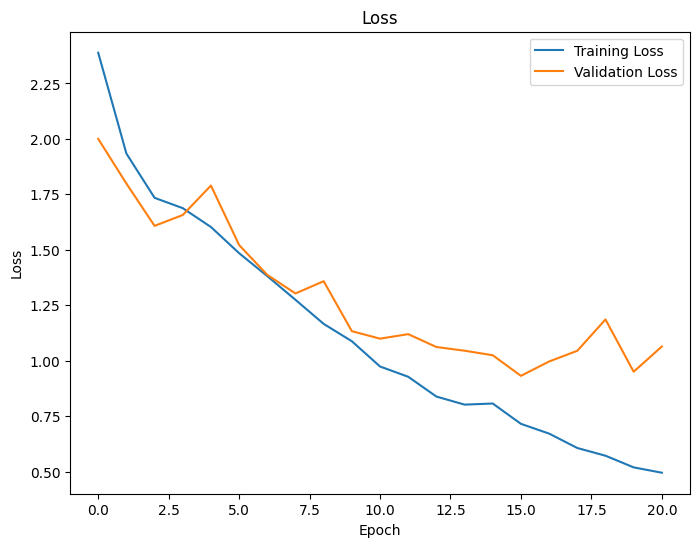

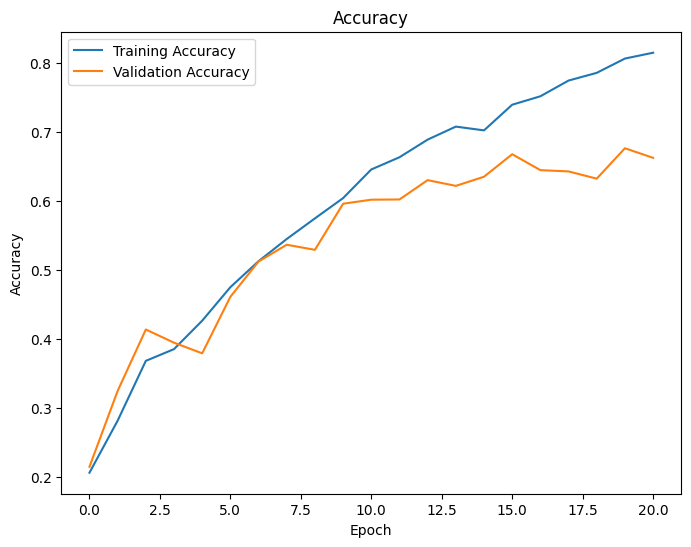

In [26]:
draw_plots(vgg16_model_history)

In [27]:
loss, accuracy = vgg16_model.evaluate(val_ds)
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Loss: {loss:.4f}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6647 - loss: 1.0375
Validation Accuracy: 0.6619
Validation Loss: 1.0640


In [28]:
true_labels = np.concatenate([y.numpy() for x, y in val_ds])
predictions = vgg16_model.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)

2025-02-21 07:34:37.288570: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


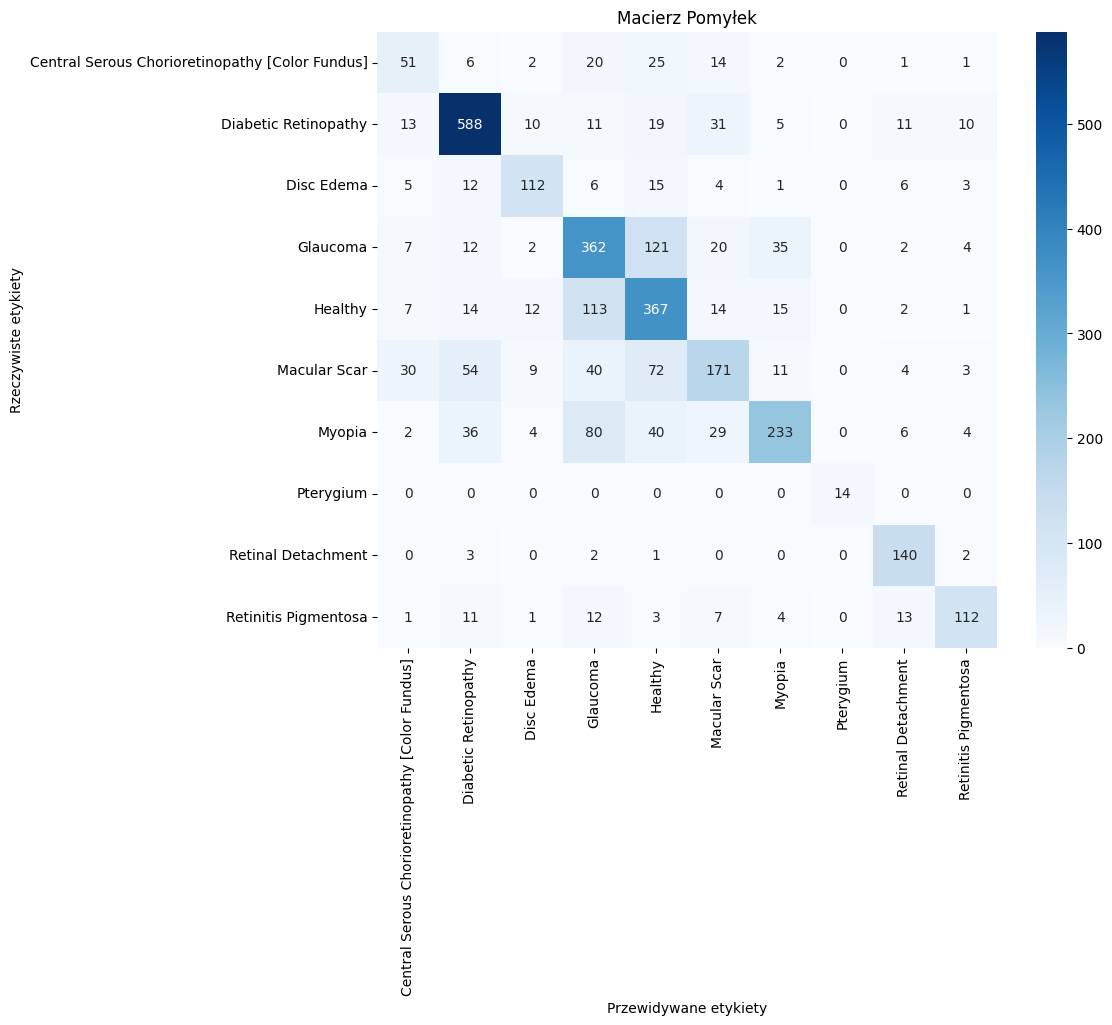

In [29]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Przewidywane etykiety")
plt.ylabel("Rzeczywiste etykiety")
plt.title("Macierz Pomyłek")
plt.show()

In [30]:
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

Classification Report:
                                                 precision    recall  f1-score   support

Central Serous Chorioretinopathy [Color Fundus]       0.44      0.42      0.43       122
                           Diabetic Retinopathy       0.80      0.84      0.82       698
                                     Disc Edema       0.74      0.68      0.71       164
                                       Glaucoma       0.56      0.64      0.60       565
                                        Healthy       0.55      0.67      0.61       545
                                   Macular Scar       0.59      0.43      0.50       394
                                         Myopia       0.76      0.54      0.63       434
                                      Pterygium       1.00      1.00      1.00        14
                             Retinal Detachment       0.76      0.95      0.84       148
                           Retinitis Pigmentosa       0.80      0.68      0.74       1

### VGG-16 rozszerzony o dodatkowe warstwy

In [45]:
vgg16_model_enhanced = tf.keras.Sequential([
    vgg16,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(len(class_names))
])

In [46]:
vgg16_model_enhanced.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [47]:
vgg16_enhanced_history = vgg16_model_enhanced.fit(
  train_ds,
  validation_data=val_ds,
  epochs=40,
  callbacks = [early_stopping]
)

Epoch 1/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 57s 64ms/step - accuracy: 0.2722 - loss: 2.1881 - val_accuracy: 0.4982 - val_loss: 1.7585
Epoch 2/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 48s 60ms/step - accuracy: 0.4544 - loss: 1.5281 - val_accuracy: 0.5216 - val_loss: 1.3185
Epoch 3/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - accuracy: 0.5268 - loss: 1.3644 - val_accuracy: 0.4858 - val_loss: 1.4363
Epoch 4/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - accuracy: 0.4357 - loss: 1.6153 - val_accuracy: 0.3725 - val_loss: 1.6974
Epoch 5/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 49s 61ms/step - accuracy: 0.4094 - loss: 1.6563 - val_accuracy: 0.5225 - val_loss: 1.4318
Epoch 6/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 49s 60ms/step - accuracy: 0.4851 - loss: 1.4818 - val_accuracy: 0.5305 - val_loss: 2.2776
Epoch 7/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 49s 61ms/step - accuracy: 0.5147 - loss: 1.3895 - val_accuracy: 0.5397 - val_loss: 1.3032
Epoch 8/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 48s 59ms/step - accuracy: 0.5468 - loss: 1.2850 - 

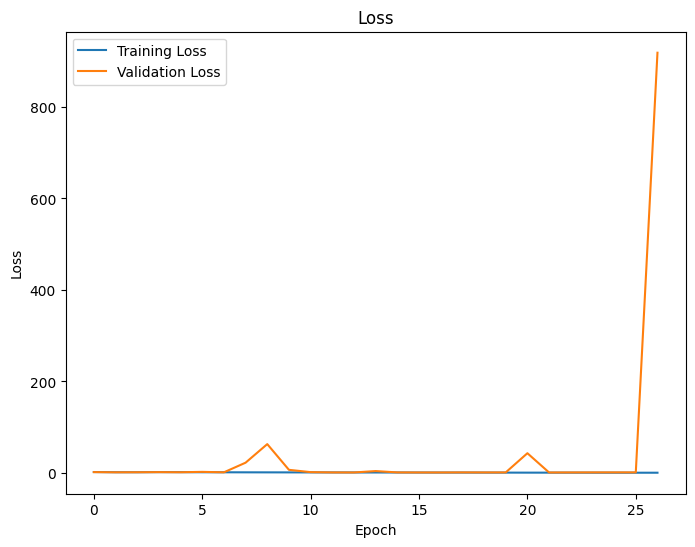

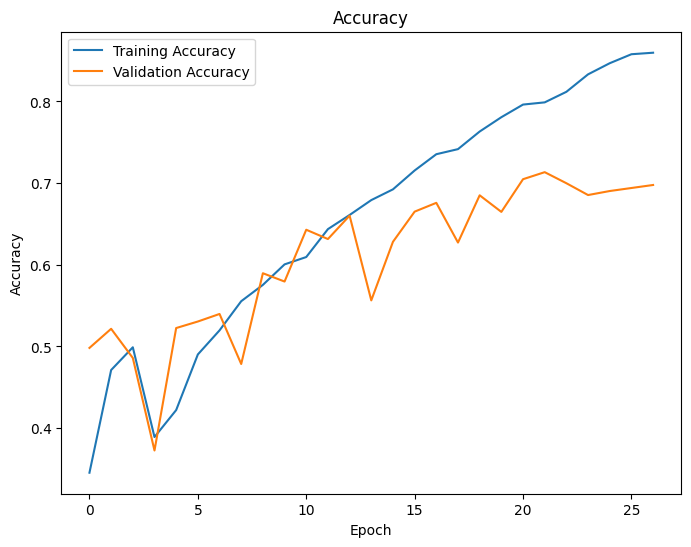

In [48]:
draw_plots(vgg16_enhanced_history)

In [49]:
loss, accuracy = vgg16_model_enhanced.evaluate(val_ds)
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Loss: {loss:.4f}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7043 - loss: 2067.3606
Validation Accuracy: 0.6977
Validation Loss: 918.7371


In [50]:
true_labels = np.concatenate([y.numpy() for x, y in val_ds])
predictions = vgg16_model_enhanced.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)

2025-02-21 08:23:01.894889: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


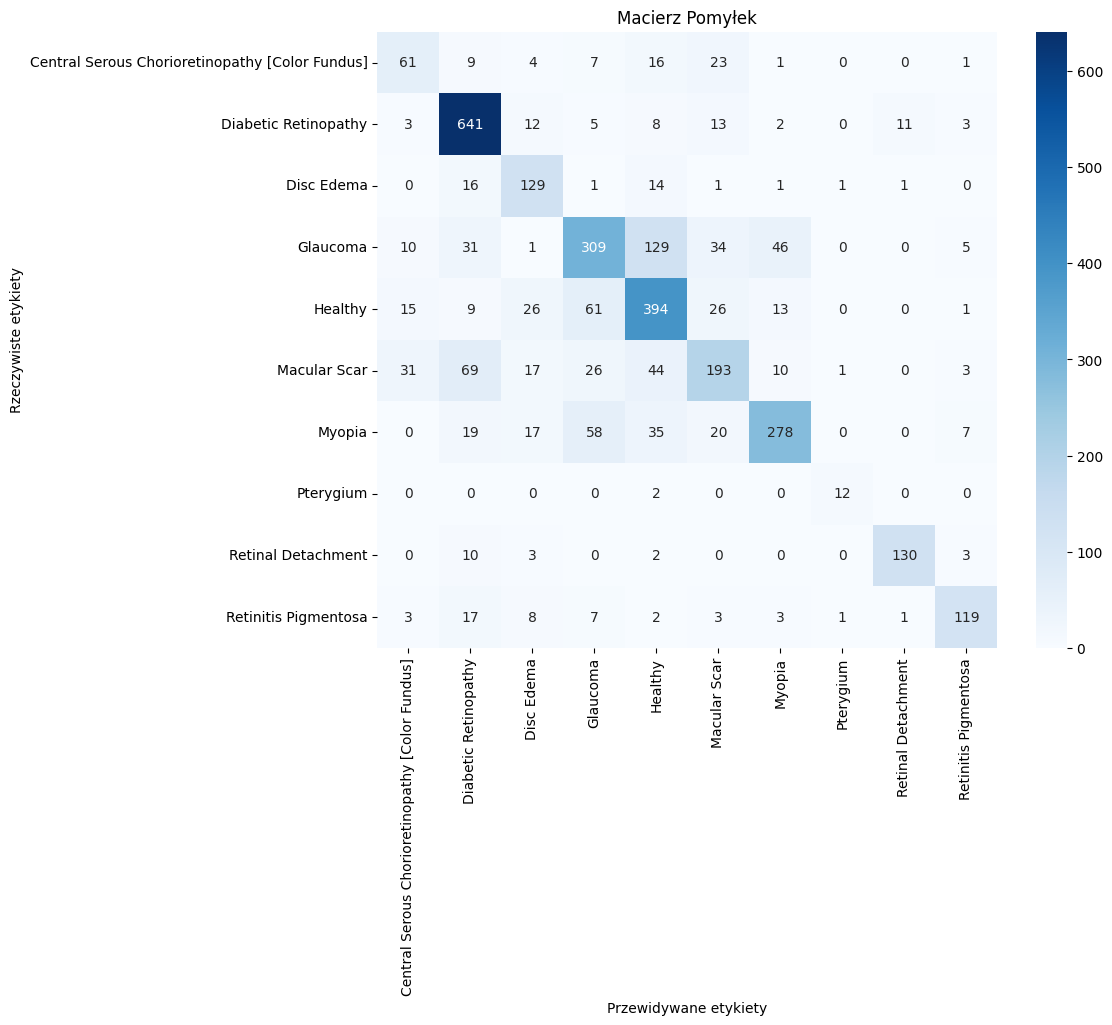

In [51]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Przewidywane etykiety")
plt.ylabel("Rzeczywiste etykiety")
plt.title("Macierz Pomyłek")
plt.show()

In [52]:
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

Classification Report:
                                                 precision    recall  f1-score   support

Central Serous Chorioretinopathy [Color Fundus]       0.50      0.50      0.50       122
                           Diabetic Retinopathy       0.78      0.92      0.84       698
                                     Disc Edema       0.59      0.79      0.68       164
                                       Glaucoma       0.65      0.55      0.59       565
                                        Healthy       0.61      0.72      0.66       545
                                   Macular Scar       0.62      0.49      0.55       394
                                         Myopia       0.79      0.64      0.71       434
                                      Pterygium       0.80      0.86      0.83        14
                             Retinal Detachment       0.91      0.88      0.89       148
                           Retinitis Pigmentosa       0.84      0.73      0.78       1

### DenseNet

In [15]:
dense_net = tf.keras.applications.DenseNet121(
            input_shape=(100, 100, 3),
            include_top=False,
            weights='imagenet'
        )

In [23]:
dense_net_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    dense_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names))
])

In [24]:
dense_net_model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
dense_net_history = dense_net_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=40,
  callbacks = [early_stopping]
)

Epoch 1/40


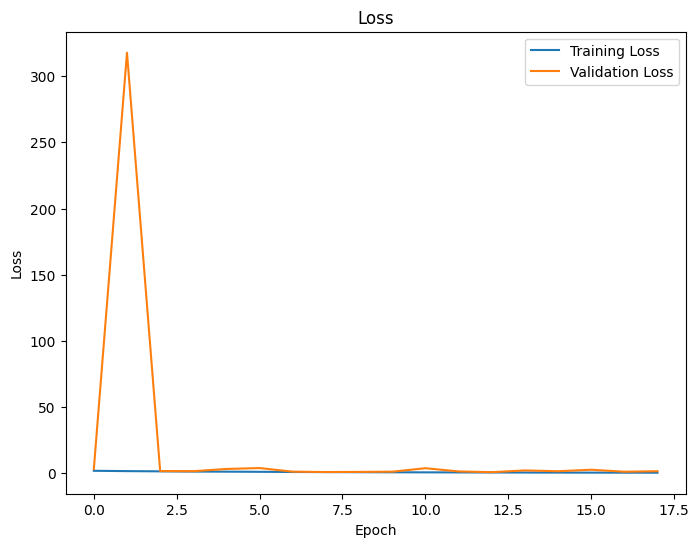

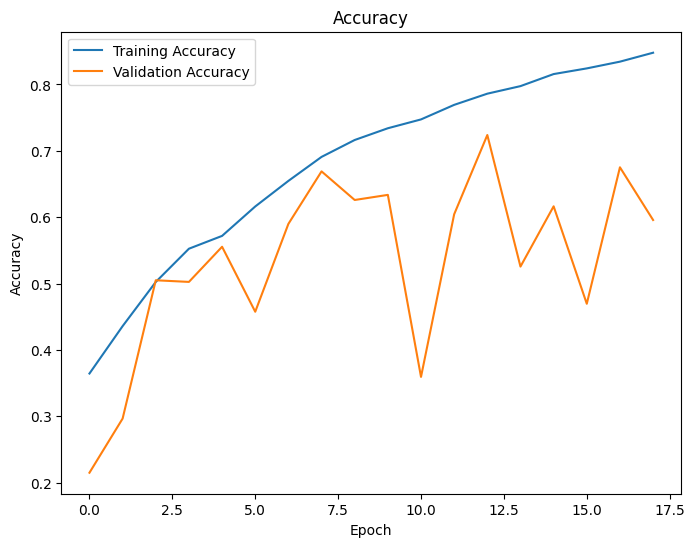

In [30]:
draw_plots(dense_net_history)

In [19]:
loss, accuracy = dense_net_model.evaluate(val_ds)
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Loss: {loss:.4f}')

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6344 - loss: 1.3563
Validation Accuracy: 0.6259
Validation Loss: 1.3848


In [20]:
true_labels = np.concatenate([y.numpy() for x, y in val_ds])
predictions = dense_net_model.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)

2025-02-20 18:44:04.608259: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


102/102 ━━━━━━━━━━━━━━━━━━━━ 17s 111ms/step


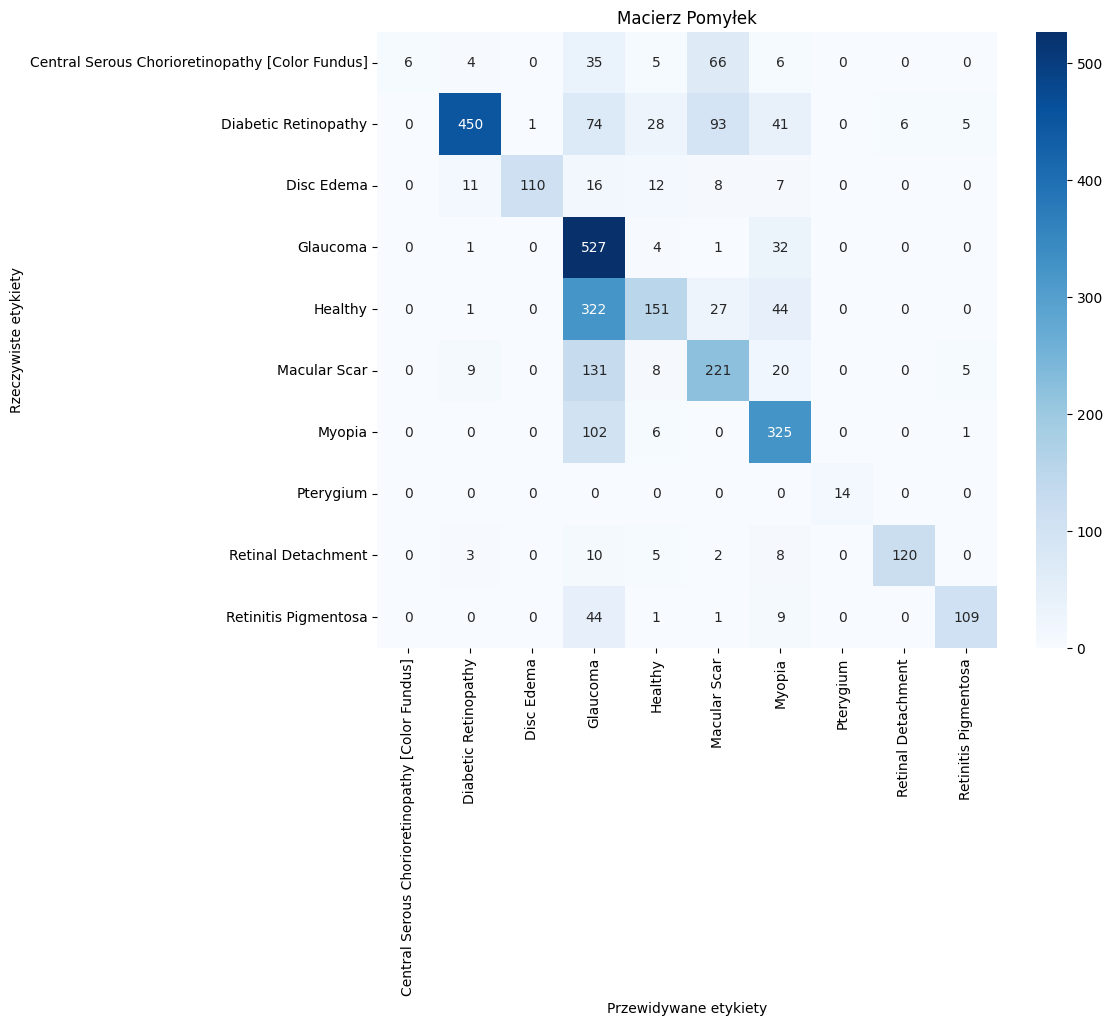

In [21]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Przewidywane etykiety")
plt.ylabel("Rzeczywiste etykiety")
plt.title("Macierz Pomyłek")
plt.show()

In [22]:
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

Classification Report:
                                                 precision    recall  f1-score   support

Central Serous Chorioretinopathy [Color Fundus]       1.00      0.05      0.09       122
                           Diabetic Retinopathy       0.94      0.64      0.76       698
                                     Disc Edema       0.99      0.67      0.80       164
                                       Glaucoma       0.42      0.93      0.58       565
                                        Healthy       0.69      0.28      0.39       545
                                   Macular Scar       0.53      0.56      0.54       394
                                         Myopia       0.66      0.75      0.70       434
                                      Pterygium       1.00      1.00      1.00        14
                             Retinal Detachment       0.95      0.81      0.88       148
                           Retinitis Pigmentosa       0.91      0.66      0.77       1

### ResNet

In [16]:
res_net = tf.keras.applications.ResNet50V2(
        input_shape=(100, 100, 3),
        include_top=False,
        weights='imagenet'
    )

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [17]:
res_net_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    res_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(class_names))
])

In [18]:
res_net_model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [19]:
res_net_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [20]:
res_net_history = res_net_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=40,
  callbacks = [early_stopping]
)

Epoch 1/40


I0000 00:00:1740123594.953070   42914 service.cc:148] XLA service 0x7f1858002240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740123594.953366   42914 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-02-21 08:39:55.413539: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740123597.402386   42914 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-21 08:39:59.314294: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14731', 92 bytes spill stores, 92 bytes spill loads

I0000 00:00:1740123612.676240   42914 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


813/813 ━━━━━━━━━━━━━━━━━━━━ 93s 77ms/step - accuracy: 0.4671 - loss: 1.5485 - val_accuracy: 0.3451 - val_loss: 2.6626
Epoch 2/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 39s 47ms/step - accuracy: 0.6507 - loss: 0.9655 - val_accuracy: 0.5102 - val_loss: 1.7380
Epoch 3/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.7178 - loss: 0.7672 - val_accuracy: 0.5859 - val_loss: 1.3790
Epoch 4/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - accuracy: 0.7635 - loss: 0.6238 - val_accuracy: 0.3944 - val_loss: 3.2549
Epoch 5/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.8098 - loss: 0.4960 - val_accuracy: 0.4667 - val_loss: 2.5809
Epoch 6/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - accuracy: 0.8395 - loss: 0.4296 - val_accuracy: 0.3815 - val_loss: 3.4542
Epoch 7/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 39s 48ms/step - accuracy: 0.8707 - loss: 0.3527 - val_accuracy: 0.4098 - val_loss: 3.8386
Epoch 8/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.8844 - loss: 0.3154 - val_accurac

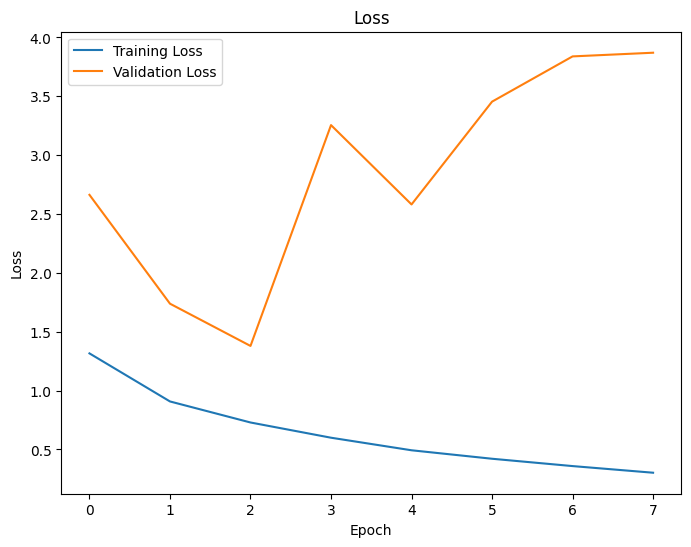

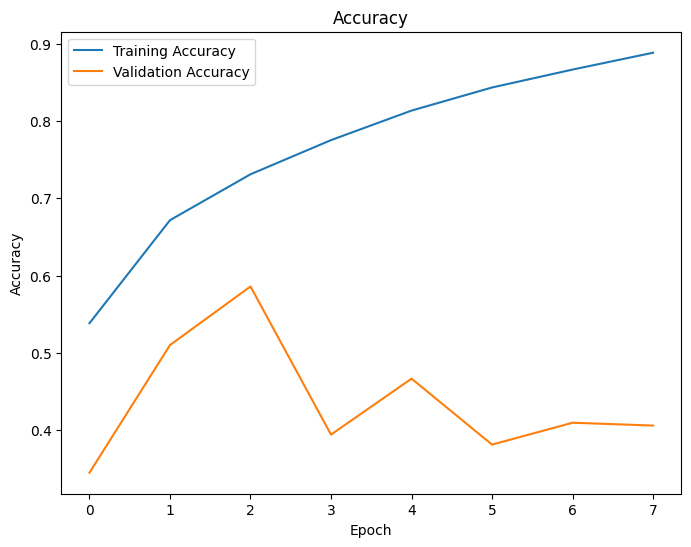

In [21]:
draw_plots(res_net_history)

In [36]:
loss, accuracy = res_net_model.evaluate(val_ds)
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Loss: {loss:.4f}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6857 - loss: 1.0183
Validation Accuracy: 0.6853
Validation Loss: 1.0380


In [37]:
true_labels = np.concatenate([y.numpy() for x, y in val_ds])
predictions = res_net_model.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)

 18/203 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

2025-02-21 08:59:23.024449: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


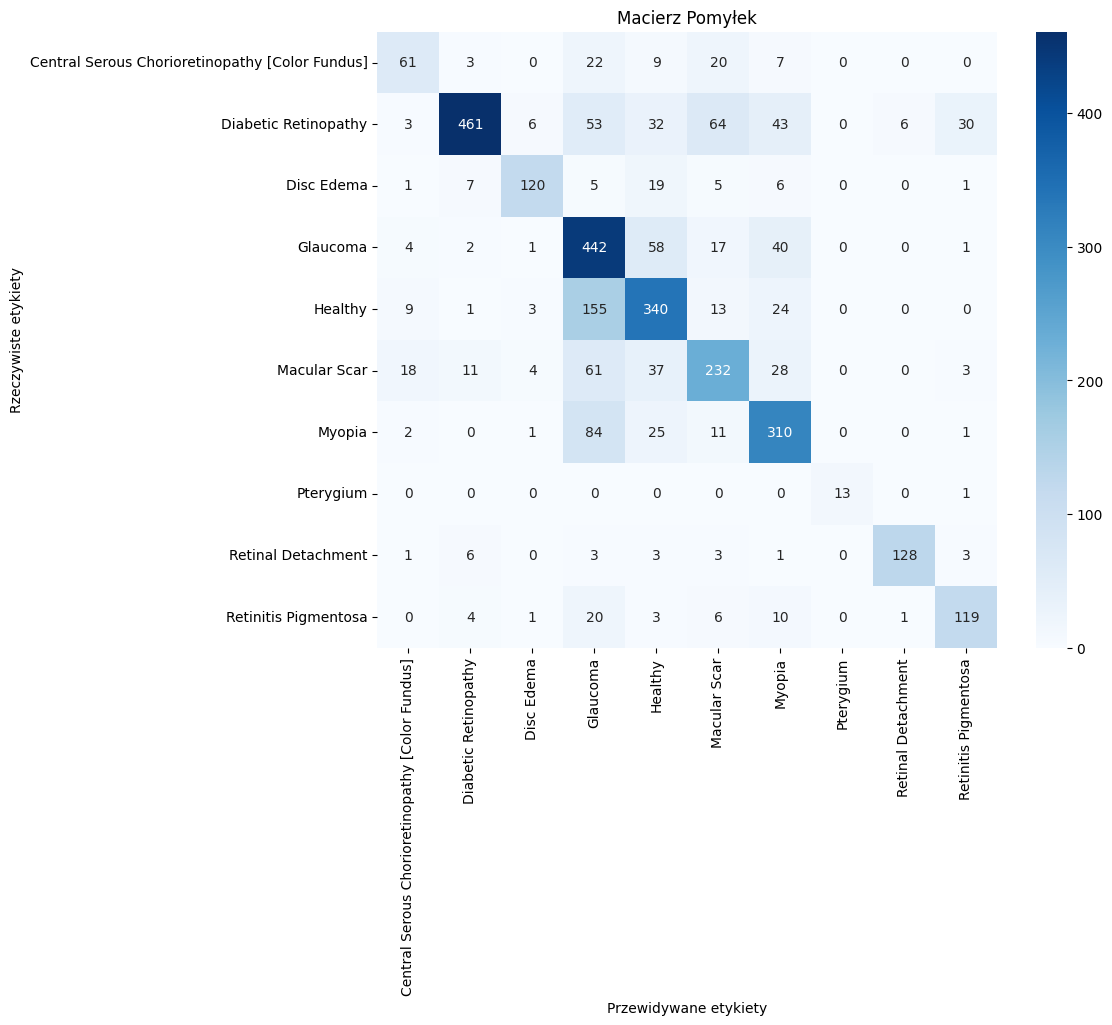

In [38]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Przewidywane etykiety")
plt.ylabel("Rzeczywiste etykiety")
plt.title("Macierz Pomyłek")
plt.show()

In [39]:
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

Classification Report:
                                                 precision    recall  f1-score   support

Central Serous Chorioretinopathy [Color Fundus]       0.62      0.50      0.55       122
                           Diabetic Retinopathy       0.93      0.66      0.77       698
                                     Disc Edema       0.88      0.73      0.80       164
                                       Glaucoma       0.52      0.78      0.63       565
                                        Healthy       0.65      0.62      0.63       545
                                   Macular Scar       0.63      0.59      0.61       394
                                         Myopia       0.66      0.71      0.69       434
                                      Pterygium       1.00      0.93      0.96        14
                             Retinal Detachment       0.95      0.86      0.90       148
                           Retinitis Pigmentosa       0.75      0.73      0.74       1

### ResNet z dodatkowymi warstwami

In [27]:
res_net_model_enhanced = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    res_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(class_names))
])

In [28]:
res_net_model_enhanced.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [29]:
res_net_history_enhanced = res_net_model_enhanced.fit(
  train_ds,
  validation_data=val_ds,
  epochs=40,
  callbacks = [early_stopping]
)

Epoch 1/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 80s 65ms/step - accuracy: 0.7723 - loss: 0.7109 - val_accuracy: 0.4190 - val_loss: 3.0104
Epoch 2/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.8593 - loss: 0.4102 - val_accuracy: 0.3371 - val_loss: 3.7683
Epoch 3/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.8828 - loss: 0.3451 - val_accuracy: 0.7075 - val_loss: 1.0269
Epoch 4/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.9002 - loss: 0.2942 - val_accuracy: 0.6998 - val_loss: 1.1295
Epoch 5/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.9134 - loss: 0.2637 - val_accuracy: 0.3384 - val_loss: 3.4951
Epoch 6/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.9127 - loss: 0.2570 - val_accuracy: 0.6502 - val_loss: 1.2619
Epoch 7/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.9287 - loss: 0.2219 - val_accuracy: 0.6133 - val_loss: 1.6264
Epoch 8/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.9337 - loss: 0.2097 - 

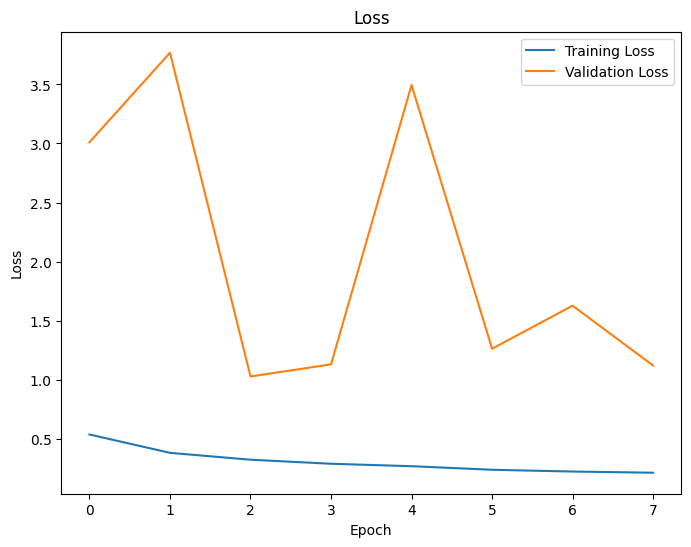

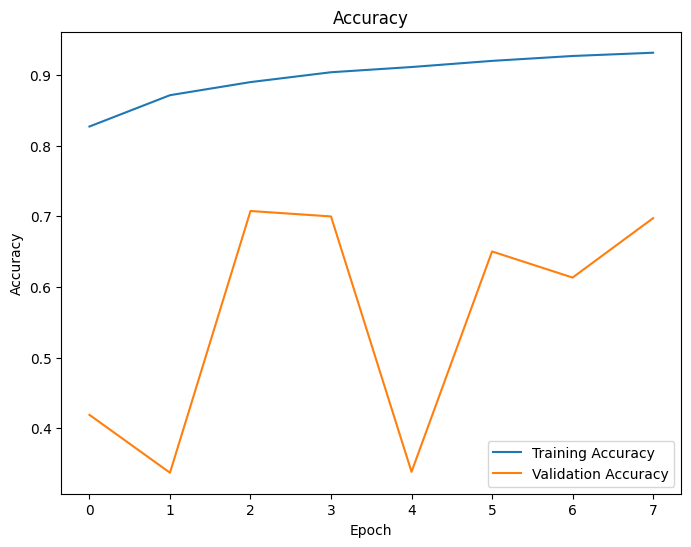

In [30]:
draw_plots(res_net_history_enhanced)

In [41]:
loss, accuracy = res_net_model_enhanced.evaluate(val_ds)
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Loss: {loss:.4f}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7019 - loss: 1.0922
Validation Accuracy: 0.6974
Validation Loss: 1.1195


In [42]:
true_labels = np.concatenate([y.numpy() for x, y in val_ds])
predictions = res_net_model_enhanced.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)

203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


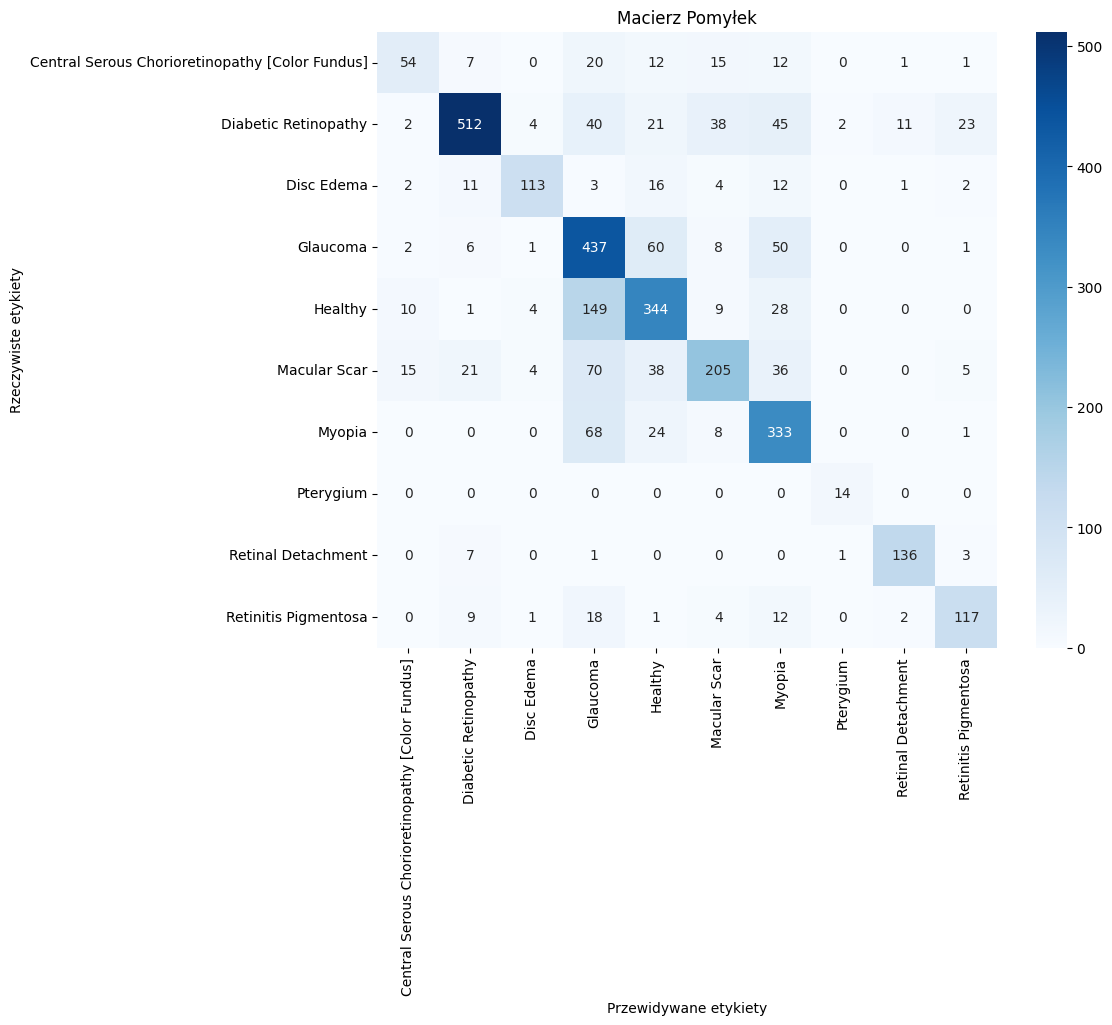

In [43]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Przewidywane etykiety")
plt.ylabel("Rzeczywiste etykiety")
plt.title("Macierz Pomyłek")
plt.show()

In [44]:
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

Classification Report:
                                                 precision    recall  f1-score   support

Central Serous Chorioretinopathy [Color Fundus]       0.64      0.44      0.52       122
                           Diabetic Retinopathy       0.89      0.73      0.81       698
                                     Disc Edema       0.89      0.69      0.78       164
                                       Glaucoma       0.54      0.77      0.64       565
                                        Healthy       0.67      0.63      0.65       545
                                   Macular Scar       0.70      0.52      0.60       394
                                         Myopia       0.63      0.77      0.69       434
                                      Pterygium       0.82      1.00      0.90        14
                             Retinal Detachment       0.90      0.92      0.91       148
                           Retinitis Pigmentosa       0.76      0.71      0.74       1

### EfficientNet

In [16]:
efficient_net = tf.keras.applications.EfficientNetB3(
    input_shape=(100, 100, 3),
    include_top=False,
    weights='imagenet'
)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [26]:
efficient_net_model = tf.keras.Sequential([
    efficient_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(class_names))
])

In [27]:
efficient_net_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 4, 4, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        15,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,798,905 (41.19 MB)

 Trainable params: 10,711,602 (40.86 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [28]:
efficient_net_model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
efficient_net_history = efficient_net_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=40,
  callbacks = [early_stopping]
)

Epoch 1/40


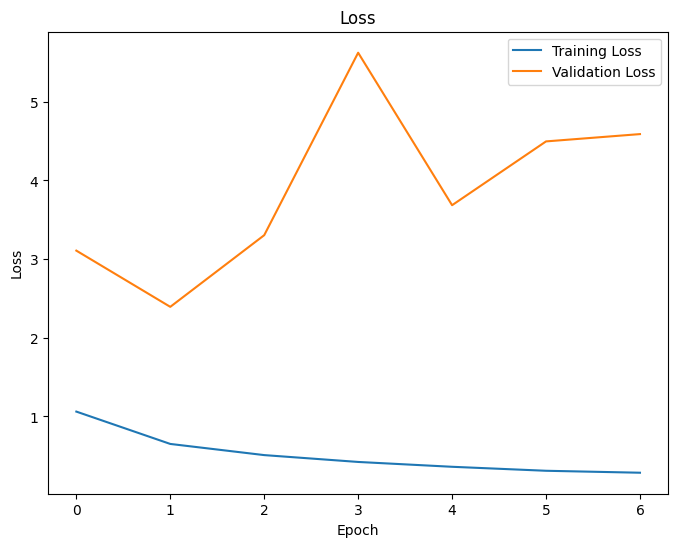

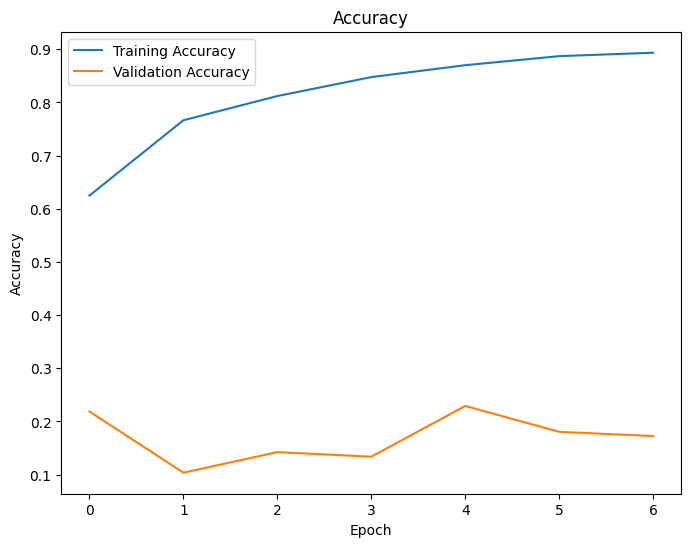

In [21]:
draw_plots(efficient_net_history)

In [22]:
loss, accuracy = efficient_net_model.evaluate(val_ds)
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Loss: {loss:.4f}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.1750 - loss: 4.5087
Validation Accuracy: 0.1724
Validation Loss: 4.5883


In [23]:
true_labels = np.concatenate([y.numpy() for x, y in val_ds])
predictions = efficient_net_model.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)

2025-02-21 09:26:04.079893: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step


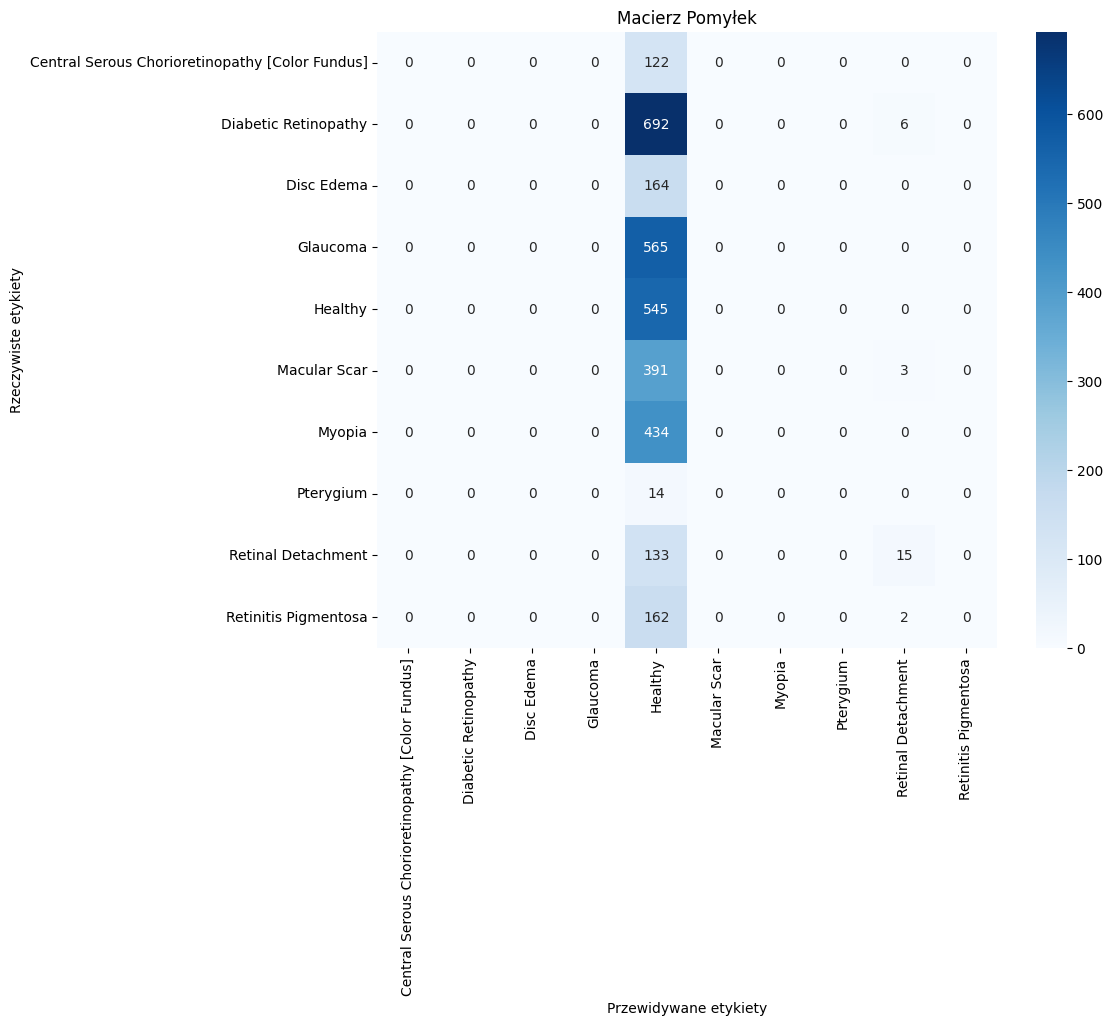

In [24]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Przewidywane etykiety")
plt.ylabel("Rzeczywiste etykiety")
plt.title("Macierz Pomyłek")
plt.show()

In [25]:
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

Classification Report:
                                                 precision    recall  f1-score   support

Central Serous Chorioretinopathy [Color Fundus]       0.00      0.00      0.00       122
                           Diabetic Retinopathy       0.00      0.00      0.00       698
                                     Disc Edema       0.00      0.00      0.00       164
                                       Glaucoma       0.00      0.00      0.00       565
                                        Healthy       0.17      1.00      0.29       545
                                   Macular Scar       0.00      0.00      0.00       394
                                         Myopia       0.00      0.00      0.00       434
                                      Pterygium       0.00      0.00      0.00        14
                             Retinal Detachment       0.58      0.10      0.17       148
                           Retinitis Pigmentosa       0.00      0.00      0.00       1

/home/michal/EyeDiseaseClassification/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michal/EyeDiseaseClassification/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/michal/EyeDiseaseClassification/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## Hiperparametryzacja
Ponieważ modelem który poradził sobie najlepiej z analizowanymi danymi był ResNet rozszerzony o dodatkowe warstwy, przeprowadzimy na nim hiperparametryzację.

In [15]:
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch, Hyperband

In [16]:
class TunedModel(HyperModel):
    def build(self, hp):
        base_model = tf.keras.applications.ResNet50V2(
            input_shape=(100, 100, 3),
            include_top=False,
            weights='imagenet'
        )

        base_model.trainable = True
        fine_tune_at = hp.Int('fine_tune_at', min_value=80, max_value=len(base_model.layers), step=25)

        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False

        model = tf.keras.Sequential([
            tf.keras.layers.Rescaling(1./255),
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(len(class_names), activation='softmax')
        ])

        initial_lr = hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6])
        decay_steps = hp.Int('decay_steps', min_value=1000, max_value=20000, step=1000)
        decay_rate = hp.Float('decay_rate', min_value=0.85, max_value=0.99, step=0.01)
        learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_lr,
            decay_steps=decay_steps,
            decay_rate=decay_rate,
            staircase=True
        )

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate_schedule),
            loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )

        return model

In [17]:
tuned_model = TunedModel()

In [19]:
tuner = RandomSearch(
    tuned_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='tuner',
    project_name='tuned_resnet'
)

Reloading Tuner from tuner/tuned_resnet/tuner0.json


In [19]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
fine_tune_at (Int)
{'default': None, 'conditions': [], 'min_value': 80, 'max_value': 190, 'step': 25, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0001, 'conditions': [], 'values': [0.0001, 1e-05, 1e-06], 'ordered': True}
decay_steps (Int)
{'default': None, 'conditions': [], 'min_value': 1000, 'max_value': 20000, 'step': 1000, 'sampling': 'linear'}
decay_rate (Float)
{'default': 0.85, 'conditions': [], 'min_value': 0.85, 'max_value': 0.99, 'step': 0.01, 'sampling': 'linear'}


In [20]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    early_stopping,
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)
]

In [21]:
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=callbacks
)

Trial 5 Complete [00h 38m 28s]
val_accuracy: 0.7524630725383759

Best val_accuracy So Far: 0.7783251106739044
Total elapsed time: 03h 18m 12s


In [37]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)  

{'fine_tune_at': 105, 'learning_rate': 1e-05, 'decay_steps': 12000, 'decay_rate': 0.98}


In [44]:
optimizer = tf.keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate'))
best_model.compile(
    optimizer=optimizer,
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [45]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,696,842 (90.40 MB)

 Trainable params: 19,839,306 (75.68 MB)

 Non-trainable params: 3,857,536 (14.72 MB)

In [46]:
best_model_history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=callbacks
)

Epoch 1/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 56s 49ms/step - accuracy: 0.9863 - loss: 0.2170 - val_accuracy: 0.7909 - val_loss: 1.3071 - learning_rate: 1.0000e-05
Epoch 2/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.9871 - loss: 0.2085 - val_accuracy: 0.7977 - val_loss: 1.2937 - learning_rate: 1.0000e-05
Epoch 3/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.9927 - loss: 0.1864 - val_accuracy: 0.8002 - val_loss: 1.2602 - learning_rate: 1.0000e-05
Epoch 4/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.9927 - loss: 0.1827 - val_accuracy: 0.7965 - val_loss: 1.3004 - learning_rate: 1.0000e-05
Epoch 5/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.9938 - loss: 0.1751 - val_accuracy: 0.7965 - val_loss: 1.2905 - learning_rate: 1.0000e-05
Epoch 6/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.9910 - loss: 0.1761 - val_accuracy: 0.7894 - val_loss: 1.2847 - learning_rate: 1.0000e-05
Epoch 7/40
813/813 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/ste

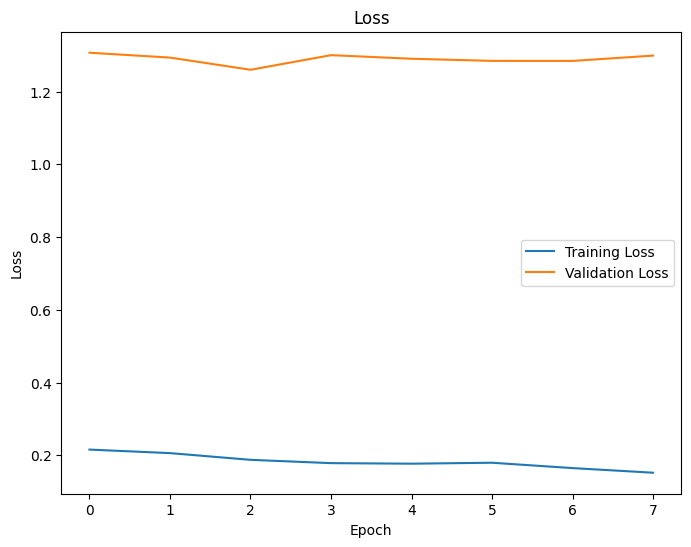

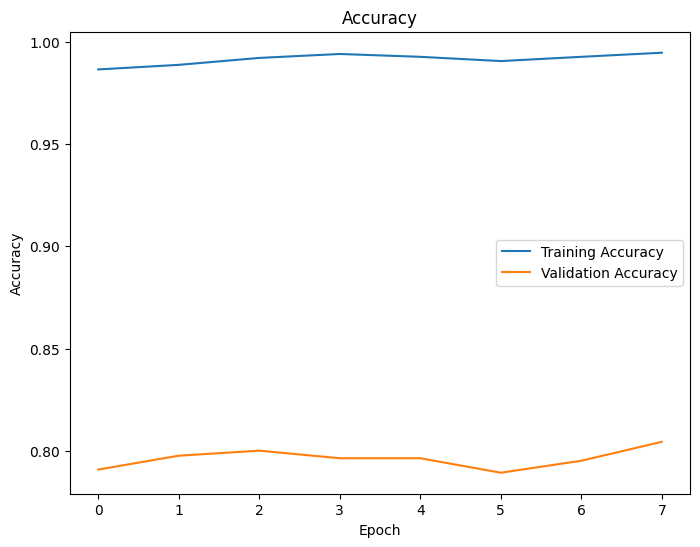

In [47]:
draw_plots(best_model_history)

In [48]:
loss, accuracy = best_model.evaluate(val_ds)
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation Loss: {loss:.4f}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8041 - loss: 1.2945
Validation Accuracy: 0.8045
Validation Loss: 1.2992


In [49]:
true_labels = np.concatenate([y.numpy() for x, y in val_ds])
predictions = best_model.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)

2025-02-21 16:54:05.667713: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


203/203 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


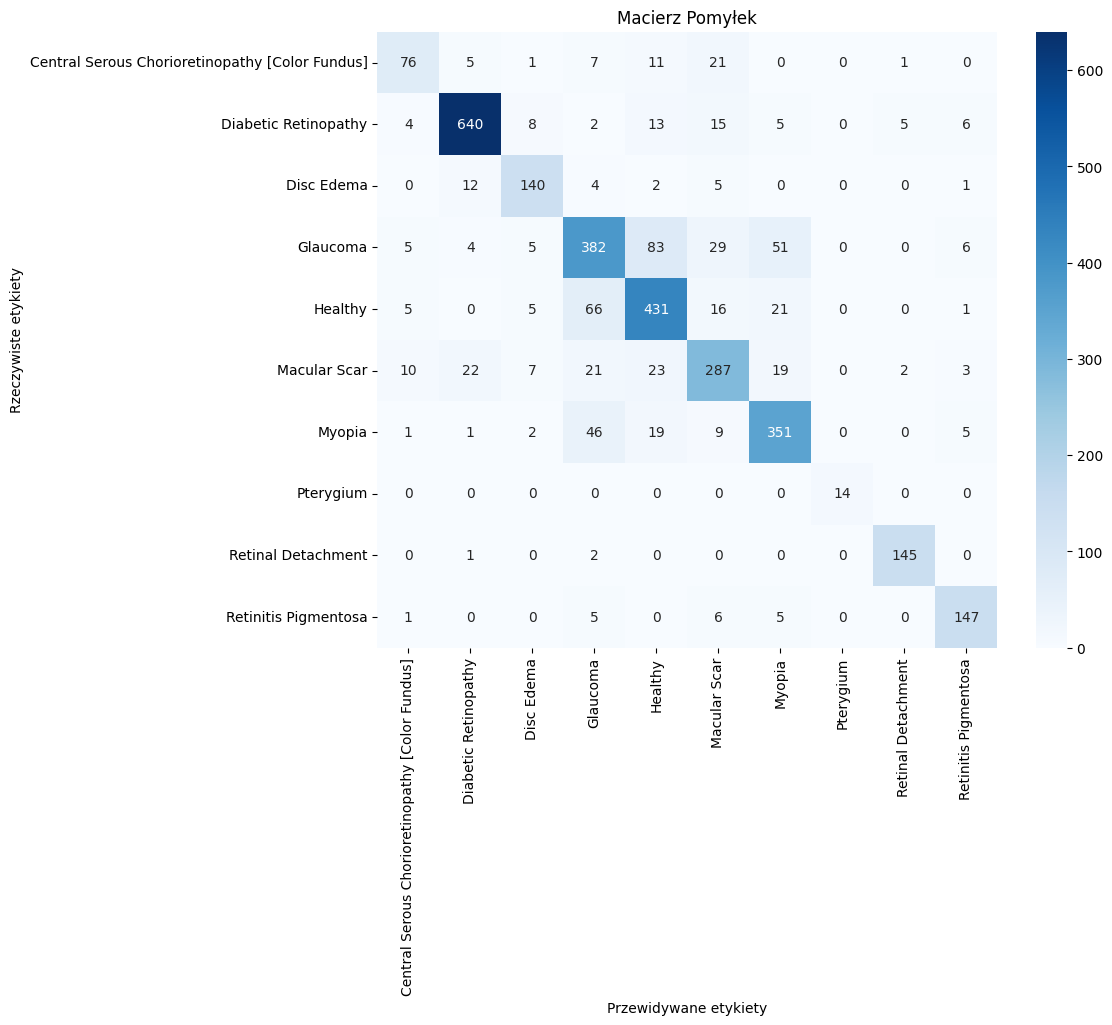

In [50]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Przewidywane etykiety")
plt.ylabel("Rzeczywiste etykiety")
plt.title("Macierz Pomyłek")
plt.show()

In [51]:
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

Classification Report:
                                                 precision    recall  f1-score   support

Central Serous Chorioretinopathy [Color Fundus]       0.75      0.62      0.68       122
                           Diabetic Retinopathy       0.93      0.92      0.93       698
                                     Disc Edema       0.83      0.85      0.84       164
                                       Glaucoma       0.71      0.68      0.69       565
                                        Healthy       0.74      0.79      0.76       545
                                   Macular Scar       0.74      0.73      0.73       394
                                         Myopia       0.78      0.81      0.79       434
                                      Pterygium       1.00      1.00      1.00        14
                             Retinal Detachment       0.95      0.98      0.96       148
                           Retinitis Pigmentosa       0.87      0.90      0.88       1

In [52]:
best_model.save('final_model.keras')

### Wnioski z uczenia modelu
W procesie uczenia, dzięki wcześniejszemu zastosowaniu hiperparametryzacji, udało się osiągnąć dokładnośc rzędu 80%. Jest to wynik wyraźnie lepszy niż we wcześniejszych próbach, szczególnie tych korzystających z klasycznych modeli uczenia maszynowego. Model najgorzej radzi sobie z ropoznawaniem obrazów zdrowego oka oraz należących do klasy Macular Scar (Blizna plamki żółtej). Najlepiej radzi sobie z rozpoznawaniem obrazów należących do klasy Pterygium (Skrzydlik), chociaż ten wynik może wynikać z małej ilości obrazów w tej klasie.

## XAI

In [99]:
import shap
from keras.preprocessing import image
from skimage.segmentation import slic
from keras.applications.resnet50 import preprocess_input
from matplotlib.colors import LinearSegmentedColormap


In [76]:
file = dataset_path + "/Glaucoma/Glaucoma1.jpg"
img = image.load_img(file, target_size=(100, 100))


In [77]:
img_orig = image.img_to_array(img)

In [79]:
segments_slic = slic(img_orig, n_segments=50, compactness=30, sigma=3)

In [83]:
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean((0,1))
    out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j,:] = background
    return out
def f(z):
    return best_model.predict(preprocess_input(mask_image(z, segments_slic, img_orig, 255)))

In [84]:
explainer = shap.KernelExplainer(f, np.zeros((1,50)))
shap_values = explainer.shap_values(np.ones((1,50)), nsamples=100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


2025-02-21 18:42:10.128894: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1502', 220 bytes spill stores, 576 bytes spill loads



4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


100%|██████████| 1/1 [00:09<00:00,  9.50s/it]


In [85]:
preds = best_model.predict(preprocess_input(np.expand_dims(img_orig.copy(), axis=0)))
top_preds = np.argsort(-preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


In [87]:
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

In [91]:
shap_values.shape

(1, 50, 10)

In [96]:
def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

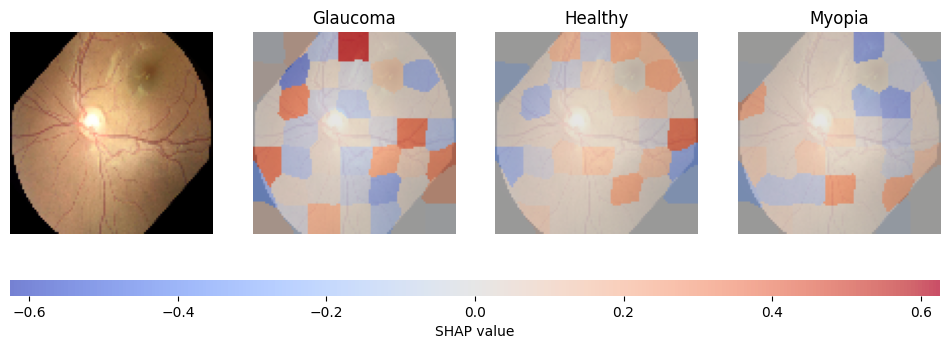

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))

inds = top_preds[0]
axes[0].imshow(img)
axes[0].axis('off')

max_val = np.max([np.max(np.abs(shap_values[0][:, j])) for j in range(shap_values.shape[-1])])

for i in range(3):
    selected_class = inds[i]
    m = fill_segmentation(shap_values[0][:, selected_class], segments_slic)

    axes[i+1].set_title(class_names[selected_class])

    axes[i+1].imshow(img)

    im = axes[i+1].imshow(m, cmap='coolwarm', alpha=0.7, vmin=-max_val, vmax=max_val)  

    axes[i+1].axis('off')

cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
plt.show()

### Wnioski z SHAPa

Pozytywnym wnioskiem jaki można wyciągnąć z widocznej powyżej mapy istotności SHAP jest to, iż wszystkie obszary które model uznaje za ważne dla przypisania obrazu do danej klasy znajdują się wewnątrz faktycznego obszaru oka. Częstym błędem który można zauważyć podczas stosowania modeli uczenia maszynowego do problemów klasyfikacji obrazów, jest to, że modele uczą się rozpoznawać obrazy po nieistotnych szczegółach, takich jak np. elemnty tła. Chociaż wszystkie obrazy wykorzystane w tym projekcie mają czarne tło, to nadal istniało ryzyko, że model nauczy się rozpoznawać choroby np. po kształcie obrazu oka. Wydaje się jednak, że udało się uniknąć tego błędu. W przypadku widocznym na powyższej ilustracji model, przewidując dla zdjęcia klasę Glaucoma (tj. jaskra) największe znaczenie przypisał obszarowi na samej górze zdjęcia, gdzie widoczne jest wyraźne przebarwienie, oraz obszarowi po po prawej stronie oka, gdzie również obraz jest ciemniejszy. W przypadku grup do których obraz nie został zakwalifikowany można zauważyć, że brakuje obszarów o tak dużej istotności oraz obszary które model wziął pod uwagę przy klasyfikacji wydają się być bardziej rozproszone.